In [30]:
# GAN (적대적 신경망)

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
# 생성자 모델 (Generator)

generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
# 128 : 임의의 노드 수 , 7*7 upsampling 궁극적으로 >> 14*14 >> 28*28 만드는게 목표 
# input_dim : 임의의 100차원 크기의 random vector를 준비해서 집어 넣겠다.
# activation = LeakyReLU(0.2) : 0 보다 작을 경우 0.2 곱해서 출력한다. 
generator.add(BatchNormalization())
# 배치 정규화 : 입력 데이터 평균은 0, 분산은 1이 되게 재배치 
generator.add(Reshape((7,7,128))) # 튜플개념 
generator.add(UpSampling2D()) #14*14로 변환 # 자동으로 2배로 만들어준다. 
generator.add(Conv2D(64, kernel_size=5, padding='same')) # 패딩 후에 줄인다(Conv).
# 5*5 filter(kernel) 사용, padding='same' : zero padding
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) #28*28로 변환
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
# tanh >> -1~1 사이로 출력 

In [32]:
# 판별자 (discriminator)

# -- Feature Extraction (특징 추출 ) --
discriminator = Sequential()
discriminator.add(Conv2D(64,kernel_size=5, strides=2, input_shape=(28,28,1),padding='same'))
# strides=2 >> pooling 과정 대체한다. >> 가로/세로 크기가 더 줄어들어 새로운 특징이 추출되는 효과
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2))) 
discriminator.add(Dropout(0.3))
# -------------------------------------------
discriminator.add(Flatten()) # 2차원 >>> 1차원
discriminator.add(Dense(1,activation='sigmoid')) # 분류문제니까 tanh아님.
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
# 판별자 자신이 학습되지 않게 학습 기능 꺼준다. (매우 중요)

In [33]:
# GAN NETWORK (생성자와 판별자 모델 연결)

ginput = Input(shape=(100,))
# 무작위로 100개의 vector 집어 넣는다. 
dis_output = discriminator(generator(ginput)) 
# 생성된 28*28 이미지 판별자의 입력값이 들어간다.
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy',optimizer='adam')
# 참 거짓 분류(이진 분류)
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_16 (Sequential)  (None, 28, 28, 1)         865281    
                                                                 
 sequential_17 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [36]:
# 신경망을 실행시키는 함수 만들기

def gan_train(epoch, batch_size, saving_interval):
    # MNIST 데이터를 불러옴
    (x_train,_),(_,_) = mnist.load_data()
    # mnist 데이터를 사용하되, 이미지만 사용하기 때문에 테스트 과정은 필요없어 x_train만 불러온다.
    x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
    # 가로 세로 28*28, 흑백 : 1로 설정
    x_train = (x_train - 127.5) / 127.5
    # 픽셀 값 : 0 ~ 255 사이의 값 
    # 이전에 255로 나누어 줄 때는 이를 0 ~ 1 사이의 값으로 바꾸었던 것이다.
    # 여기서는 127.5를 빼준 후 127.5로 나누어 줌으로 인해 -1~1 사이의 값으로 바뀌게 된다.
    
    # batch_size : 한번에 몇개의 실제 이미지와 가상 이미지를 판별자에게 넣을 지 결정 
    true = np.ones((batch_size, 1))
    # 모두 참 (1)인 배열 생성 
    fake = np.zeros((batch_size, 1)) 
    
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        # 실제 이미지를 무작위하게 선택, 불러온다.
        # 0부터 x_train.shape[0]가지 숫자 중 하나를 무작위 추출, batch_size만큼 반복
        imgs = x_train[idx]
        # 선택된 숫자에 해당하는 이미지 불러오기 
        d_loss_real = discriminator.train_on_batch(imgs, true)
        # 생성한 이미지와 모두 참(1)인 true 배열 y에 놓음
        # 여기에 차이가 발생하면 loss(손실)
        
        # 가상 이미지를 판별자에 입력하는 부분
        noise = np.random.normal(0,1,(batch_size,100))
        # 생성자에 넣을 가상 이미지 생성 >> noise
        # 정수가 아니기 때문에 정규분포 형태로 만들어준다.
        # 0에서 1까지 batch_size만큼 100열을 뽑음
        
        gan_imgs = generator.predict(noise)
        # noise(생성된 가상 이미지)가 생성자에 입력(예측), 결과값이 gan_imgs로 저장 
        d_loss_fake = discriminator.train_on_batch(gan_imgs, fake)
        # 만들어진 가짜 이미지(gan_imgs)에 fake 배열(모두 0) 레이블이 붙는다. 
        
        # 판별자와 생성자의 오차 계산
        # d_loss_real, d_loss_fake 값을 더해서 둘로 나눈 평균 >> 판별자의 오차
        d_loss = 0.5 * np.add(d_loss_real,d_loss_fake)
        g_loss = gan.train_on_batch(noise,true)
        
        print('epoch:%d'%i,'d_loss:%.4f'%d_loss,'g_loss:%.4f'%g_loss)
        
        if i % saving_interval ==0:
            # r,c = 5,5
            noise = np.random.normal(0,1,(25,100))
            gan_imgs = generator.predict(noise)
            
            # rescale imgs 0~1 
            gan_imgs = 0.5 * gan_imgs + 0.5 
            
            fig, axs = plt.subplots(5,5)
            count =0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gan_imgs[count, :,:,0],cmap='gray')
                    axs[j,k].axis('off')
                    count += 1
            fig.savefig("./data/gan_images/gan_mnist_new_%d.png"%i)
            

1/1 [==============================] - 0s 81ms/step
epoch:0 d_loss:0.6667 g_loss:0.7849
1/1 [==============================] - 0s 21ms/step
epoch:1 d_loss:0.4025 g_loss:0.4011
1/1 [==============================] - 0s 19ms/step
epoch:2 d_loss:0.3189 g_loss:0.0701
1/1 [==============================] - 0s 20ms/step
epoch:3 d_loss:0.6795 g_loss:0.0100
1/1 [==============================] - 0s 20ms/step
epoch:4 d_loss:1.0237 g_loss:0.0178
1/1 [==============================] - 0s 21ms/step
epoch:5 d_loss:0.9280 g_loss:0.1109
1/1 [==============================] - 0s 21ms/step
epoch:6 d_loss:0.5675 g_loss:0.7034
1/1 [==============================] - 0s 20ms/step
epoch:7 d_loss:0.5355 g_loss:1.2329
1/1 [==============================] - 0s 20ms/step
epoch:8 d_loss:0.6366 g_loss:1.2301
1/1 [==============================] - 0s 21ms/step
epoch:9 d_loss:0.5463 g_loss:1.1095
1/1 [==============================] - 0s 21ms/step
epoch:10 d_loss:0.4719 g_loss:1.0198
1/1 [==========================

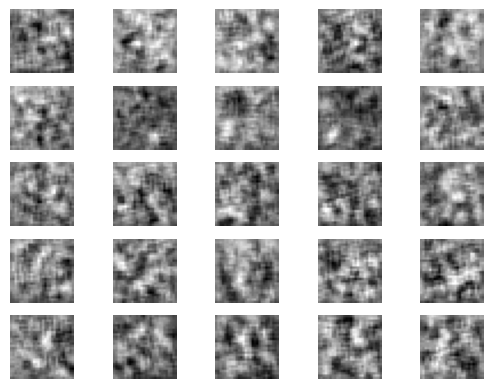

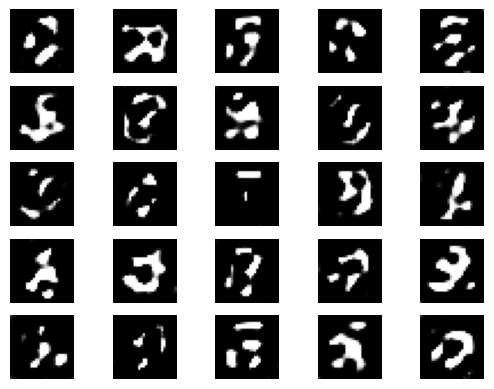

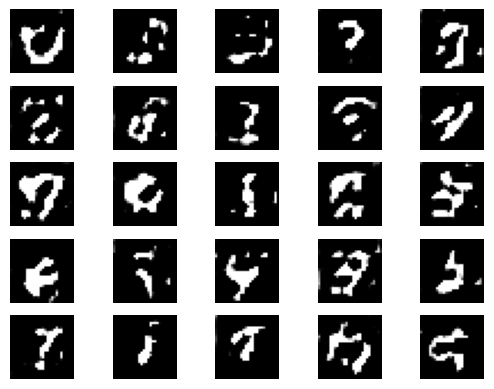

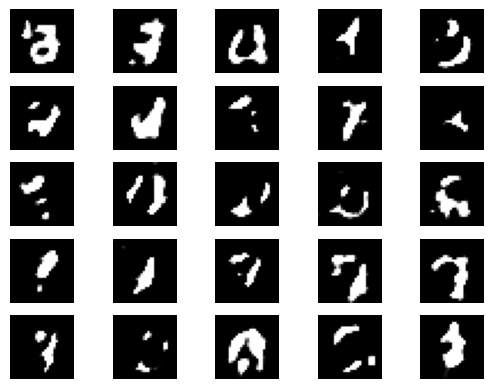

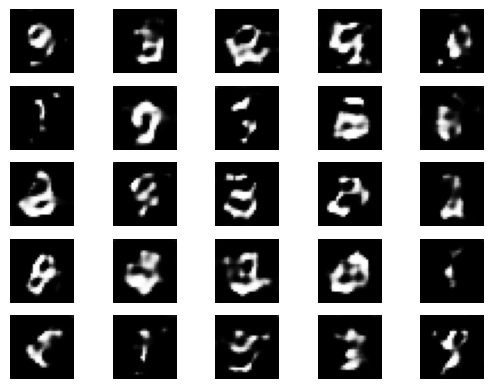

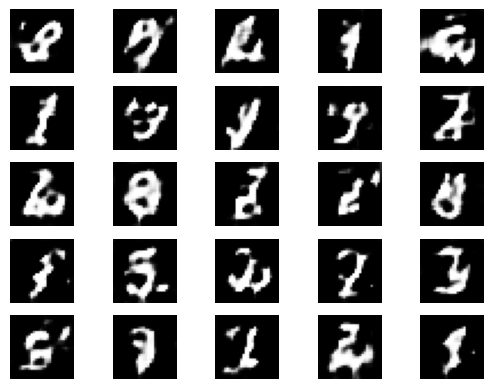

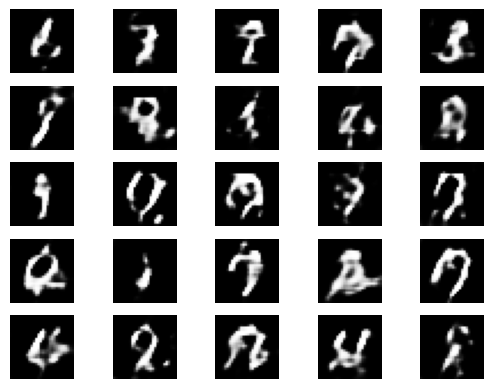

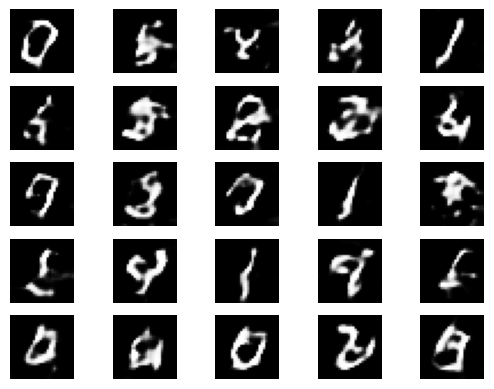

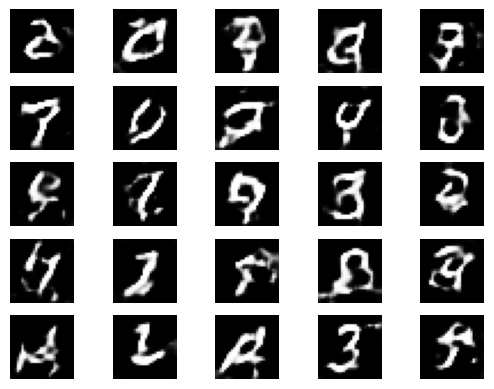

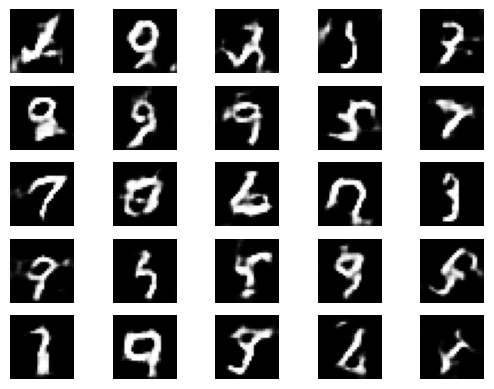

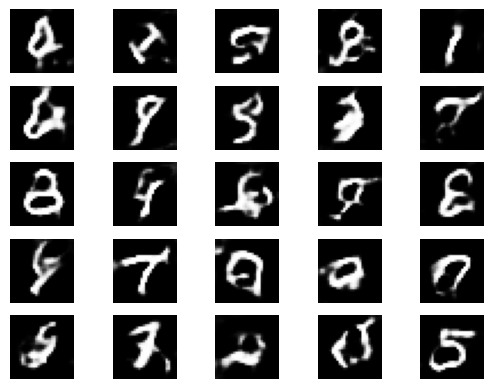

In [37]:
gan_train(2001,32,200)
# 2000번 반복 , batch_size =32,200번 마다 결과 저장되게 한다. 